# creating a melody with the model.
Based on the musegan model

### anaconda
- Maak een nieuw environment in anaconda.

    ``` cmd
    conda create -n gan python=3.6
    ```

    ``` cmd
    conda activate gan 
    ```

- Installeer de packages

    ``` cmd
    conda install -c anaconda cudatoolkit
    ```

    ``` cmd
    conda install -c conda-forge cudnn
    ```

    ``` cmd
    pip install tensorflow==2.5
    ```

    ``` cmd
    pip install music21
    ```

    ``` cmd
    pip install imageio
    ```

    ``` cmd
    conda install matplotlib
    ```

    ``` cmd
    pip install scikit-learn 
    ```

run the imports

In [1]:
from music21 import converter, instrument, note, chord, stream
import sys
import numpy as np
from imageio import imwrite

from PIL import Image

from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adagrad
from matplotlib import pyplot
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

import pickle

from tensorflow.keras.models import load_model
from decimal import Decimal
import re

import glob


c:\Users\antje\anaconda3\envs\musegan\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


# Preprocessing the data

The dataset that is used is the weimar jazz database. Download the midifiles via this link: [download](https://jazzomat.hfm-weimar.de/download/downloads/RELEASE2.0_mid_unquant.zip)

place the midi files in a folder with the name 'data'

In [2]:
import os
import numpy as np
path = './data'
# os.chdir(path)
midiz = os.listdir(path)
midis = []
for midi in midiz:
    midis.append(path+'/'+ midi)
# os.chdir('..')
print(len(midis))

456


Function to convert midi files to piano roll images.

In [3]:
def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite(midi_path.split("/")[-1].replace(".mid",f"_{instrument_name}_{index}.png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

Convert the midi files and gets a list of the piano roll images.

In [4]:
# converts all the midi files, They are also reshaped into the shape (100,106). 106 is the height of the program, 
# as this is the number of possible notes on a midi file. 
# Also, it is much easier to work with squares for convolutional transpositions.

import os
import numpy as np
# import py_midicsv as pm

new_dir = './images'
os.chdir(new_dir)

path = '../data'
midiz = os.listdir(path)
midis = []
for midi in midiz:
    midis.append('../data'+'/'+midi)
    
print(midis[0])
for midi in midis:
    # print(os.getcwd())
    try:
        # midi = '.'+ midi
        midi2image(midi)
    except Exception as e:
        print(e)


imagez = os.listdir('./')
images = []
for image in imagez:
    images.append('./'+image)

print(images[0])

../data/ArtPepper_Anthropology_FINAL.mid
cannot handle ticks per frame: 144
cannot handle ticks per frame: 144
cannot handle ticks per frame: 144
./ArtPepper_BluesForBlanche_FINAL_Melody_0.png


In [5]:
imagez = os.listdir('./')
images = []

for file_path in imagez:
    if not file_path.endswith(".png"):
        os.remove(file_path)

imagez = os.listdir('./')

for image in imagez:
    images.append('./'+image)

print(images[0])
print(len(images))

./ArtPepper_BluesForBlanche_FINAL_Melody_0.png
4802


Changes the shape of the piano roll images to 106x106.

In [6]:
try: 
    for img_path in images:
        basewidth = 106
        # img_path = midi.split('/')[-1].replace(".mid",".png")
        # img_path = "/"+img_path
        print(os.getcwd())
        # os.chdir("..")
        
        # print(os.getcwd())
        print(img_path)
        img = Image.open(img_path)
        hsize = 106
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)
        print(img.size)
        img.save(img_path)
except Exception as e:
    print(e)

os.chdir("..")

c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_0.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_1.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_10.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_11.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_12.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_13.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_14.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_15.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_16.png
(106, 106)
c:\Researchproject\Code\musegan\images
./ArtPepper_BluesForBlanche_FINAL_Melody_17.png
(106, 106)
c:\Researchproject\Cod

Get the pixel values of the piano roll images. For the input of the model.

In [7]:
# goes to the directory that contains all the images and records all the pixel values
import os
from PIL import Image
from matplotlib import pyplot as plt 
import numpy as np
path = './images'
os.getcwd()
img_list = os.listdir(path)
def access_images(img_list,path,length):
    pixels = []
    imgs = []
    for i in range(length):
        if 'png' in img_list[i]:
            try:
                img = Image.open(path+'/'+img_list[i],'r')
                img = img.convert('1')
                # print(img.size)
                pix = np.array(img.getdata())
                pix = pix.astype('float32')
                pix /= 255.0
                # print(pix.shape)
                pixels.append(pix.reshape(106,106,1))
                imgs.append(img)
            except Exception as e:
                print(e)
    return np.array(pixels),imgs
def show_image(pix_list):
    array = np.array(pix_list.reshape(106,106), dtype=np.uint8)
    new_image = Image.fromarray(array)
    new_image.show()
    
pixels,imgs = access_images(img_list,path,200)
print(img_list[0])
print(imgs[0].size)
print(pixels.shape)
print(np.unique(pixels))

ArtPepper_BluesForBlanche_FINAL_Melody_0.png
(106, 106)
(200, 106, 106, 1)
[0. 1.]


Saves the pixels in a file.

In [8]:
# save pixel values to a file
with open('./files/pixels.pkl', 'wb') as f:
    pickle.dump(pixels, f)

# save images to a file
with open('./files/imgs.pkl', 'wb') as f:
    pickle.dump(imgs, f)


load the pixels from the file.

In [9]:
# load pixel values from a file
with open('./files/pixels.pkl', 'rb') as f:
    pixels = pickle.load(f)

# load images from a file
with open('./files/imgs.pkl', 'rb') as f:
    imgs = pickle.load(f)

print(imgs[0].size)
print(pixels.shape)
print(np.unique(pixels))

(106, 106)
(200, 106, 106, 1)
[0. 1.]


# Training the model

The discriminator is trained on the real images and the generated images.

In [10]:
def define_discriminator(in_shape = (106,106,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

The generator is trained on latent points.

In [11]:
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 53 * 53
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((53, 53, 128)))
    model.add(Dense(1024))
    model.add(Conv2DTranspose(1024, (4,4), strides=(2,2), padding='same'))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(Conv2D(1, (7,7) , padding='same',activation = 'sigmoid'))
    return model

This script combines the discriminator and the generator together, so the loss from the discriminator can be backpropagated back into the generator

In [12]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

These free functions are able to generate all the parameters and data that the GAN needs to function: 
- The latent_points work as the input of the generator while 
- the fake and real samples are to train and test the discriminator.

In [46]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y
 
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [47]:
d_hist = []
g_hist = []

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            d_hist.append(d_loss)
            g_hist.append(g_loss)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

            # train the model 
            # histroy = gan_model.fit(X_gan, y_gan, epochs=1, batch_size=10, verbose=1)
            
        if (i+1) % 10 == 0:
            # summarize_performance(i, g_model, d_model, dataset, latent_dim)
            clear_output()

    # save the generator model
    g_model.save('./files/cgan_generator.h5')
    #save the discriminator model
    d_model.save('./files/cgan_discriminator.h5')
    #save the gan model
    gan_model.save('./files/cgan_gan.h5')

    #save d_hist and g_hist
    with open('./files/d_hist.txt', 'w') as f:
        for item in d_hist:
            f.write("%s " % item)
    with open('./files/g_hist.txt', 'w') as f:
        for item in g_hist:
            f.write("%s " % item)

train and save the model

In [48]:
latent_dim = 100
epochs = 12

In [49]:
# latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
# epochs = 12
print(pixels.shape)
train(g_model, d_model, gan_model, np.array(pixels), latent_dim, n_epochs=epochs)

>11, 1/20, d=0.039, g=0.744
>11, 2/20, d=0.065, g=0.766
>11, 3/20, d=0.093, g=0.763
>11, 4/20, d=0.442, g=0.698
>11, 5/20, d=0.049, g=0.673
>11, 6/20, d=0.066, g=0.670
>11, 7/20, d=0.123, g=0.663
>11, 8/20, d=0.191, g=0.637
>11, 9/20, d=0.051, g=0.636
>11, 10/20, d=0.365, g=0.590
>11, 11/20, d=0.073, g=0.578
>11, 12/20, d=0.204, g=0.559
>11, 13/20, d=0.150, g=0.531
>11, 14/20, d=0.058, g=0.533
>11, 15/20, d=0.067, g=0.548
>11, 16/20, d=0.040, g=0.560
>11, 17/20, d=0.029, g=0.573
>11, 18/20, d=0.221, g=0.571
>11, 19/20, d=0.103, g=0.572
>11, 20/20, d=0.058, g=0.588
>12, 1/20, d=0.265, g=0.594
>12, 2/20, d=0.028, g=0.604
>12, 3/20, d=0.046, g=0.623
>12, 4/20, d=0.243, g=0.611
>12, 5/20, d=0.086, g=0.615
>12, 6/20, d=0.065, g=0.631
>12, 7/20, d=0.024, g=0.646
>12, 8/20, d=0.059, g=0.662
>12, 9/20, d=0.056, g=0.685
>12, 10/20, d=0.271, g=0.671
>12, 11/20, d=0.026, g=0.665
>12, 12/20, d=0.033, g=0.673
>12, 13/20, d=0.036, g=0.685
>12, 14/20, d=0.046, g=0.701
>12, 15/20, d=0.028, g=0.718
>12

Load the model

In [17]:
# load model


g_model = load_model('./files/cgan_generator.h5')
d_model = load_model('./files/cgan_discriminator.h5')
gan_model = load_model('./files/cgan_gan.h5')

# make list of d_hist and g_hist from txt files
d_hist = []
g_hist = []

#open text file in read mode
text_file = open("./files/d_hist.txt", "r")
#read whole file to a string
hist_str = text_file.read()
#close file
text_file.close()
d_hist = hist_str.split(" ")
print(d_hist[:5])
d_hist_new = []
for x in d_hist:
    if re.search("^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$", x):
        d_hist_new.append(float(x))
    else:
        print(f"{x} is not a valid float")

print(d_hist_new[:5])
print(len(d_hist_new))

text_file = open("./files/g_hist.txt", "r")
g_hist_str = text_file.read()
text_file.close()
g_hist = g_hist_str.split(" ")
print(g_hist[5])
g_hist_new = []
for x in g_hist:
    if re.search("^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$", x):
        g_hist_new.append(float(x))
    else:
        print(f"{x} is not a valid float")

print(g_hist_new[:5])
print(len(g_hist_new))

['0.6242333054542542', '0.22766289114952087', '0.08666574954986572', '0.057448286563158035', '0.03333572298288345']
 is not a valid float
[0.6242333054542542, 0.22766289114952087, 0.08666574954986572, 0.057448286563158035, 0.03333572298288345]
2000
0.8859292268753052
 is not a valid float
[0.8498234748840332, 1.0391181707382202, 1.1263412237167358, 1.1663799285888672, 1.0644216537475586]
2000


Evaluate the discriminator and plot real and fake points

In [18]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print(epoch, acc_real, acc_fake)
    pyplot.scatter(X_real[:, 0], X_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.show()
    pyplot.close()
    # show plot 
    pyplot.imshow(x_fake[0].reshape(106,106), cmap='gray')
    pyplot.show()

100 1.0 1.0


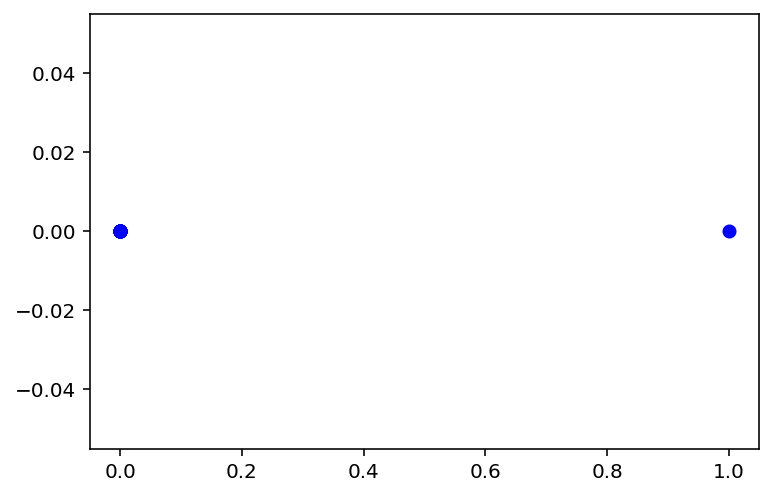

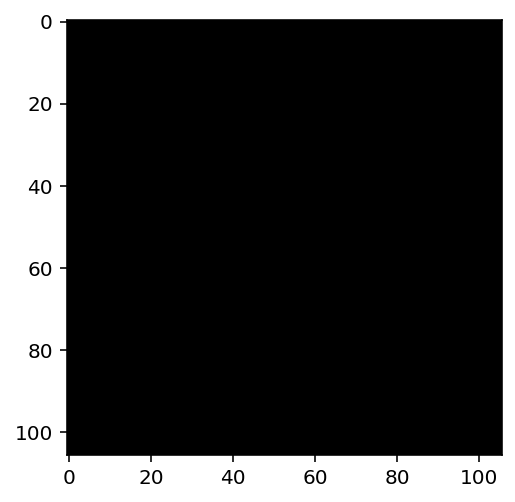

In [19]:
summarize_performance(epochs, g_model, d_model, np.array(pixels), 100)

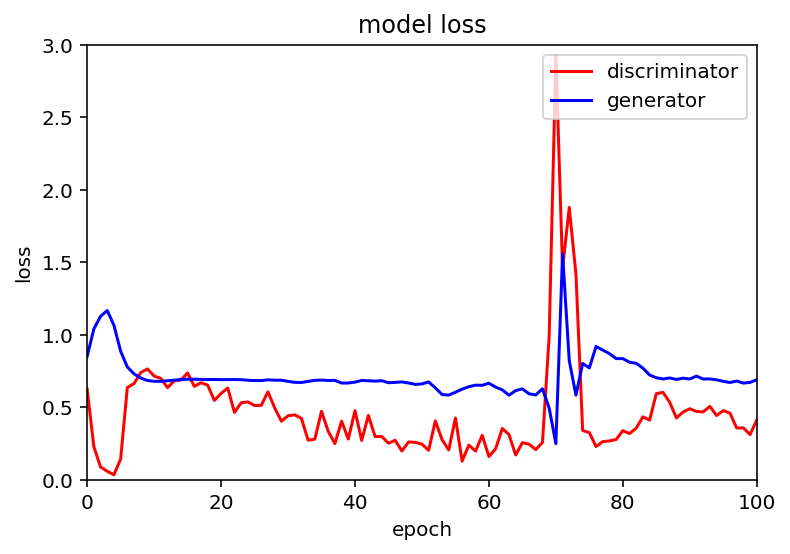

In [22]:
def plot_history(d_hist, g_hist, epochs):
    fig, ax1 = plt.subplots(1, 1)
    # Loss 
    ax1.plot(d_hist,'r')
    ax1.plot(g_hist,'b')
    ax1.set_xlim(0, 100)
    ax1.set_ylim(0,3)
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['discriminator', 'generator'], loc='upper right')

plot_history(d_hist_new, g_hist_new, epochs)

- make prediction with gan model
- show the generated samples

In [23]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    print(X.shape)
    return X

def show_generated_samples(g_model, latent_dim, n_samples=5):
    X = generate_fake_samples(g_model, latent_dim, n_samples)
    print(X.shape)
    for i in range(n_samples):
        pyplot.subplot(2, 5, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i].reshape(106,106), cmap='gray')
    pyplot.show()

(5, 106, 106, 1)
(5, 106, 106, 1)


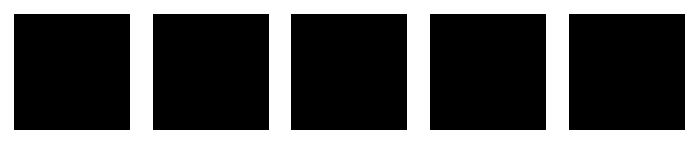

In [25]:
show_generated_samples(g_model, 100)

image to midi file

In [26]:
latent_dim = 100
n_samples = 4
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
model = g_model
latent_points = generate_latent_points(latent_dim,n_samples)
X = g_model.predict(latent_points)
print(X.shape)
for i in range(n_samples):
    array = np.array(X[i].reshape(106,106),dtype = np.uint8)
    array*= 255
    new_image = Image.fromarray(array,'L')
    new_image = new_image.save(f'./compositions/composition{i}.png')

(4, 106, 106, 1)


In [27]:
lowerBoundNote = 21
def column2notes(column):
    notes = []
    for i in range(len(column)):
        if column[i] > 255/2:
            notes.append(i+lowerBoundNote)
    return notes

resolution = 0.25
def updateNotes(newNotes,prevNotes): 
    res = {} 
    for note in newNotes:
        if note in prevNotes:
            res[note] = prevNotes[note] + resolution
        else:
            res[note] = resolution
    return res

def image2midi(image_path):
    with Image.open(image_path) as image:
        im_arr = np.frombuffer(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0]))
        except:
            im_arr = im_arr.reshape((image.size[1], image.size[0],3))
            im_arr = np.dot(im_arr, [0.33, 0.33, 0.33])
            print("Image is not grayscale, converting to grayscale")

    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model

    prev_notes = updateNotes(im_arr.T[0,:],{})
    for column in im_arr.T[1:,:]:
        notes = column2notes(column)
        # pattern is a chord
        notes_in_chord = notes
        old_notes = prev_notes.keys()
        for old_note in old_notes:
            if not old_note in notes_in_chord:
                new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
                new_note.storedInstrument = instrument.Piano()
                if offset - prev_notes[old_note] >= 0:
                    new_note.offset = offset - prev_notes[old_note]
                    output_notes.append(new_note)
                elif offset == 0:
                    new_note.offset = offset
                    output_notes.append(new_note)                    
                else:
                    print(offset,prev_notes[old_note],old_note)

        prev_notes = updateNotes(notes_in_chord,prev_notes)

        # increase offset each iteration so that notes do not stack
        offset += resolution

    for old_note in prev_notes.keys():
        new_note = note.Note(old_note,quarterLength=prev_notes[old_note])
        new_note.storedInstrument = instrument.Piano()
        new_note.offset = offset - prev_notes[old_note]

        output_notes.append(new_note)

    prev_notes = updateNotes(notes_in_chord,prev_notes)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='./compositions/'+image_path.split("/")[-1].replace(".png",".mid"))

In [28]:
for i in range(n_samples):
    image2midi(f'./compositions/composition{i}.png')

play midi samples

In [29]:
from music21 import midi
for i in range(n_samples):
    mf = midi.MidiFile()
    mf.open(f'./compositions/composition{i}.mid') 
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

### Generate music based on an input midi file. 
This generates a music piece based on the input midi file.
- make a midi file and place it in the input_midi folder

Run function to convert midi file to png file

In [ ]:
def extractNote(element):
    return int(element.pitch.ps)

def extractDuration(element):
    return element.duration.quarterLength

def get_notes(notes_to_parse):

    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    durations = []
    notes = []
    start = []

    for element in notes_to_parse:
        if isinstance(element, note.Note):
            if element.isRest:
                continue

            start.append(element.offset)
            notes.append(extractNote(element))
            durations.append(extractDuration(element))
                
        elif isinstance(element, chord.Chord):
            if element.isRest:
                continue
            for chord_note in element:
                start.append(element.offset)
                durations.append(extractDuration(element))
                notes.append(extractNote(chord_note))

    return {"start":start, "pitch":notes, "dur":durations}

def midi2image(midi_path, max_repetitions = float("inf"), resolution = 0.25, lowerBoundNote = 21, upperBoundNote = 127, maxSongLength = 100):
    mid = converter.parse(midi_path)

    instruments = instrument.partitionByInstrument(mid)

    data = {}

    try:
        i=0
        for instrument_i in instruments.parts:
            notes_to_parse = instrument_i.recurse()

            notes_data = get_notes(notes_to_parse)
            if len(notes_data["start"]) == 0:
                continue

            if instrument_i.partName is None:
                data["instrument_{}".format(i)] = notes_data
                i+=1
            else:
                data[instrument_i.partName] = notes_data

    except:
        notes_to_parse = mid.flat.notes
        data["instrument_0"] = get_notes(notes_to_parse)

    for instrument_name, values in data.items():
        # https://en.wikipedia.org/wiki/Scientific_pitch_notation#Similar_systems

        pitches = values["pitch"]
        durs = values["dur"]
        starts = values["start"]

        index = 0
        while index < max_repetitions:
            matrix = np.zeros((upperBoundNote-lowerBoundNote,maxSongLength))


            for dur, start, pitch in zip(durs, starts, pitches):
                dur = int(dur/resolution)
                start = int(start/resolution)

                if not start > index*(maxSongLength+1) or not dur+start < index*maxSongLength:
                    for j in range(start,start+dur):
                        if j - index*maxSongLength >= 0 and j - index*maxSongLength < maxSongLength:
                            matrix[pitch-lowerBoundNote,j - index*maxSongLength] = 255

            if matrix.any(): # If matrix contains no notes (only zeros) don't save it
                imwrite(midi_path.split("/")[-1].replace(".mid",f".png"),matrix.astype(np.uint8))
                index += 1
            else:
                break

path = 'input_midi/*.mid'
files = glob.glob(path)
print(files)
# midi to image
for i in range(len(files)):
    midi2image(files[i])

Changes shape of the image

In [ ]:
path = 'input_midi/*.png'
files = glob.glob(path)
print(files)
for i in range(len(files)):
    basewidth = 10
    img = Image.open(files[i])
    hsize = 10
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    print(img.size)
    img.save(files[i])

['input_midi\\tst.png']
(10, 10)


In [ ]:
print('number\t file name')
for i in range(len(files)):
    
    print(i,'\t', files[i])

midi = int(input("Enter the midi file number you want a sequel to: "))

number	 file name
0 	 input_midi\tst.png


Gets the pixels of the image so that it can be used as input for the model

In [ ]:
def access_images(path):
    pixels = []
    imgs = []
    if 'png' in path:
        try:
            img = Image.open(path, 'r')
            img = img.convert('1')
            pix = np.array(img.getdata())
            pix = pix.astype('float32')
            pix /= 255.0
            pixels.append(pix.reshape(10,10,1))
            imgs.append(img)
        except Exception as e:
            print(e)
    return np.array(pixels),imgs


pixels_test, imgs_test = access_images(files[midi])

print("size:", pixels_test.shape)

size: (1, 10, 10, 1)


change the shape of the image to the shape that the model expects

In [ ]:


# reshape image pixels to 2D array
pixels_test = pixels_test.reshape(10*10,1)

# perform PCA with 100 components
pca = PCA(n_components=1, svd_solver='full')
pca_model = pca.fit(pixels_test)
latent_points_test = pca_model.transform(pixels_test)

# # reshape latent_points to (1, 100)
latent_points_test = latent_points_test.reshape(1, 100)

c:\Users\antje\anaconda3\envs\gan\lib\site-packages\sklearn\decomposition\_pca.py:470: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


show generated samples

In [ ]:
import random
def generated_samples(g_model,n_samples=5, latent_points_test=latent_points_test):
    X_list = []
    for i in range(n_samples):
        # input = latent_points_test*random.uniform(0.5,1.5)
        latent_points_test += 0.05 * tf.random.uniform(tf.shape(latent_points_test))
        X = g_model.predict(latent_points_test)
        X_list.append(X)
    return X_list

def show_generated_samples(g_model, n_samples=5):
    X = generated_samples(g_model, n_samples)
    for i in range(n_samples):
        pyplot.subplot(2, 5, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X[i].reshape(106,106), cmap='gray')
    pyplot.show()

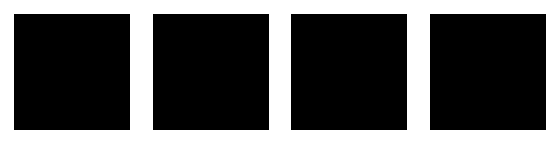

In [ ]:
n_smaples = 5
show_generated_samples(g_model, n_samples=n_samples)

Generates samples

In [ ]:
def generated_samples(g_model,n_samples=5, latent_points_test=latent_points_test):
    X_list = []
    for i in range(n_samples):
        # input = latent_points_test*random.uniform(0.5,1.5)
        latent_points_test += 0.05 * tf.random.uniform(tf.shape(latent_points_test))
        X = g_model.predict(latent_points_test)
        X_list.append(X)
    return X_list

for i in range(n_samples):
    X = generated_samples(g_model, n_samples=5)
    array = np.array(X[i].reshape(106,106),dtype = np.uint8)
    array*= 255
    new_image = Image.fromarray(array,'L')
    new_image = new_image.save(f'./compositions/composition_examplebased{i}.png')

Converts the samples to midi files

In [ ]:
for i in range(n_samples):
    image2midi(f'./compositions/composition_examplebased{i}.png')

plays the midi files. the midi files are in the folder compositions. The filename looks like this: 
- composition_examplebased[number of different midifiles].mid

In [ ]:
from music21 import midi
for i in range(n_samples):
    mf = midi.MidiFile()
    mf.open(f'./compositions/composition_examplebased{i}.mid') 
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')